# Task Overview

In this task, your goal is to verify the impact of data noise level in neural network training.
You should use MLP architecture trained on MNIST dataset (like in previous lab exercises).


We will experiment with two setups:
1. Pick X. Take X% of training examples and reassign their labels to random ones. Note that we don't change anything in the test set.
2. Pick X. During each training step, for each sample, change values of X% randomly selected pixels to random values. Note that we don't change anything in the test set.

For both setups, check the impact of various levels of noise (various values of X%) on model performance. Show plots comparing crossentropy (log-loss) and accuracy with varying X%, and also comparing two setups with each other.
Prepare short report briefly explaining the results and observed trends. Consider questions like "why accuracy/loss increases/decreases so quickly/slowly", "why Z is higher in setup 1/2" and any potentially surprising things you see on charts.

### Potential questions, clarifications
* Q: Can I still use sigmoid/MSE loss?
  * You should train your network with softmax and crossentropy loss (log-loss), especially since you should report crossentropy loss.
* Q: When I pick X% of pixels/examples, does it have to be exactly X% or can it be X% in expectation?
  * A: It's fine either way.
* Q: When I randomize pixels, should I randomize them again each time a particular example is drawn (each training step/epoch) or only once before training?
  * A: Each training step/epoch.
* Q: When I randomize labels, should I randomize them again each time a particular example is drawn (each training step/epoch) or only once before training?
  * A: Only once before training.
* Q: What is the expected length of report/explanation?
  * A: There is no minimum/maximum, but between 5 (concise) and 20 sentences should be good. Don't forget about plots.
* Q: When I replace labels/pixels with random values, what random distribution should I use?
  * A: A distribution reasonably similar to the data. However, you don't need to match dataset's distribution exactly - approximation will be totally fine, especially if it's faster or easier to get.
* Q: Can I use something different than Colab/Jupyter Notebook? E.g. just Python files.
  * A: Yes, although notebook is encouraged; please include in you solution code and pdf.

# Model definition and training.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

**Model definition**

In [2]:
class Network(nn.Module):
    def __init__(self, sizes):
        super(Network, self).__init__()
        self.layers = nn.ModuleList(
           [nn.Linear(sizes[i], sizes[i + 1]) for i in range(len(sizes) - 1)]
        )
    
    def forward(self, x):
        x = torch.flatten(x, 1)

        for layer in self.layers[:-1]:
            x = layer(x)
            x = F.relu(x)
        
        x = self.layers[-1](x)
        return F.log_softmax(x, dim=1)

In [3]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    train_loss = []
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_loss.append(loss.item())
    
    return np.array([
        np.mean(train_loss), correct / len(train_loader.dataset)
    ])

In [4]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return np.array([test_loss, correct / len(test_loader.dataset)])

In [5]:
batch_size = 256
test_batch_size = 1000
epochs = 8
lr = 1e-3
use_cuda = False
seed = 256
log_interval = 64
sizes = [784, 32, 32, 10]

In [6]:
use_cuda = not use_cuda and torch.cuda.is_available()

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [7]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [8]:
import matplotlib.pyplot as plt

def plot_history(history):
    """Visualize model's performance."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
    fig.tight_layout(pad=3.0)

    ax1.plot(history['train'][:, 0], label='train_loss', c='deepskyblue')
    ax1.plot(history['test'][:, 0], label='test_loss', c='springgreen')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend()
        
    ax2.plot(history['train'][:, 1], label='train_acc', c='gold')
    ax2.plot(history['test'][:, 1], label='test_acc', c='mediumpurple')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend()

    plt.suptitle("Model's performance")
    plt.show()

In [9]:
model = Network(sizes).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
 history1 = {k: np.zeros((epochs, 2)) for k in ['train', 'test']}

for epoch in range(1, epochs + 1):
    history1['train'][epoch - 1] = train(
        model, device, train_loader, optimizer, epoch, log_interval
        )
    history1['test'][epoch - 1] = test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.328902
Train Epoch: 1 [16384/60000 (27%)]	Loss: 0.534325
Train Epoch: 1 [32768/60000 (54%)]	Loss: 0.352584
Train Epoch: 1 [49152/60000 (82%)]	Loss: 0.268161

Test set: Average loss: 0.2907, Accuracy: 9151/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.287796
Train Epoch: 2 [16384/60000 (27%)]	Loss: 0.301576
Train Epoch: 2 [32768/60000 (54%)]	Loss: 0.253809
Train Epoch: 2 [49152/60000 (82%)]	Loss: 0.212114

Test set: Average loss: 0.2305, Accuracy: 9314/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.212889
Train Epoch: 3 [16384/60000 (27%)]	Loss: 0.257574
Train Epoch: 3 [32768/60000 (54%)]	Loss: 0.208472
Train Epoch: 3 [49152/60000 (82%)]	Loss: 0.180120

Test set: Average loss: 0.1987, Accuracy: 9400/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.189153
Train Epoch: 4 [16384/60000 (27%)]	Loss: 0.225081
Train Epoch: 4 [32768/60000 (54%)]	Loss: 0.180559
Train Epoch: 4 [49152/60000 (82%)]	Loss: 0.155340

Test set: Average loss: 0.1782, Accu

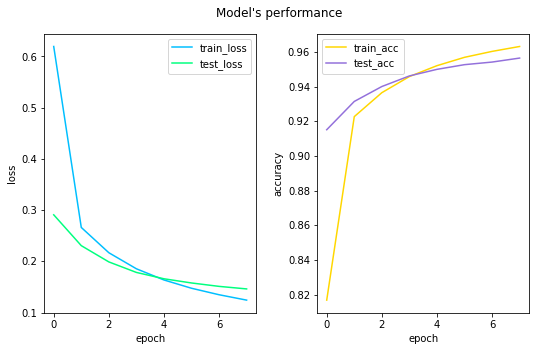

In [11]:
plot_history(history1)

# Training models in setup 1: with randomized labels.

In [12]:
from torch.distributions.categorical import Categorical


class RandomizeLabels:
    def __init__(self, percent, distribution):
        self.percent = percent
        self.distribution = distribution
        
    def __call__(self, labels):
        mask = Categorical(torch.tensor(
            [self.percent, 1 - self.percent])
        ).sample(labels.size())
        return labels * mask + (1 - mask) * Categorical(
            self.distribution).sample(labels.size())
    
    def __repr__(self):
        return self.__class__.__name__ + self.percent

In [13]:
# load training data to ensure no data contamination
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
number_values, number_counts = dataset1.targets.unique(return_counts=True)
numbers_dist = {
    k: v/len(dataset1.targets) for k, v in zip(number_values, number_counts)
}
numbers_dist = dict(sorted(numbers_dist.items(), key=lambda x: x[0]))

In [14]:
xs = np.arange(0, 1.1, 0.1)

In [15]:
history2 = {
    x: {k: np.zeros((epochs, 2)) for k in ['train', 'test']} for x in xs
}

In [16]:
for x in xs:
    print(f'Randomizing {x * 100:.2f}% of training labels')
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
    randomizer = RandomizeLabels(x, torch.tensor(list(numbers_dist.values())))
    dataset1.targets = randomizer(dataset1.targets)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)

    # forces same weight initialization for each iteration
    torch.manual_seed(seed)
    model = Network(sizes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        history2[x]['train'][epoch - 1] = train(
            model, device, train_loader, optimizer, epoch, log_interval
            )
        history2[x]['test'][epoch - 1] = test(model, device, test_loader)

Randomizing 0.00% of training labels
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.328902
Train Epoch: 1 [16384/60000 (27%)]	Loss: 0.534325
Train Epoch: 1 [32768/60000 (54%)]	Loss: 0.352584
Train Epoch: 1 [49152/60000 (82%)]	Loss: 0.268161

Test set: Average loss: 0.2907, Accuracy: 9151/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.287796
Train Epoch: 2 [16384/60000 (27%)]	Loss: 0.301576
Train Epoch: 2 [32768/60000 (54%)]	Loss: 0.253809
Train Epoch: 2 [49152/60000 (82%)]	Loss: 0.212114

Test set: Average loss: 0.2305, Accuracy: 9314/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.212889
Train Epoch: 3 [16384/60000 (27%)]	Loss: 0.257574
Train Epoch: 3 [32768/60000 (54%)]	Loss: 0.208472
Train Epoch: 3 [49152/60000 (82%)]	Loss: 0.180120

Test set: Average loss: 0.1987, Accuracy: 9400/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.189153
Train Epoch: 4 [16384/60000 (27%)]	Loss: 0.225081
Train Epoch: 4 [32768/60000 (54%)]	Loss: 0.180559
Train Epoch: 4 [49152/60000 (82%)]	Loss: 0.155340


# Training models in setup 2: with randomized pixels.

In [57]:
class RandomizePixels:
    def __init__(self, percent, distribution):
        self.percent = percent
        self.distribution = distribution
        
    def __call__(self, data):
        mask = Categorical(torch.tensor(
            [self.percent, 1 - self.percent])
        ).sample(data.size())
        randomized = Categorical(self.distribution).sample(data.size())
        return (data * mask) + ((1 - mask) * randomized / 255)
    
    def __repr__(self):
        return self.__class__.__name__ + self.percent

In [58]:
# load training data to ensure no data contamination
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
pixel_values, pixel_counts = dataset1.data.flatten().unique(return_counts=True)
pixels_dist = {
    k: v/len(dataset1.data) for k, v in zip(pixel_values, pixel_counts)
}
pixels_dist = dict(sorted(pixels_dist.items(), key=lambda x: x[0]))

In [60]:
xs = np.arange(0.0, 1.1, 0.1)

In [61]:
history3 = {
    x: {k: np.zeros((epochs, 2)) for k in ['train', 'test']} for x in xs
}

In [63]:
for x in xs:
    print(f'Randomizing {x * 100}% of pixels in each training image')
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        RandomizePixels(x, torch.tensor(list(pixels_dist.values()))),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=train_transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)

    # forces same weight initialization for each iteration
    torch.manual_seed(seed)
    model = Network(sizes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        history3[x]['train'][epoch - 1] = train(
            model, device, train_loader, optimizer, epoch, log_interval
            )
        history3[x]['test'][epoch - 1] = test(model, device, test_loader)

Randomizing 0.0% of pixels in each training image
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.328902
Train Epoch: 1 [16384/60000 (27%)]	Loss: 0.534325
Train Epoch: 1 [32768/60000 (54%)]	Loss: 0.352584
Train Epoch: 1 [49152/60000 (82%)]	Loss: 0.268161

Test set: Average loss: 0.2907, Accuracy: 9151/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.287796
Train Epoch: 2 [16384/60000 (27%)]	Loss: 0.301576
Train Epoch: 2 [32768/60000 (54%)]	Loss: 0.253809
Train Epoch: 2 [49152/60000 (82%)]	Loss: 0.212114

Test set: Average loss: 0.2305, Accuracy: 9314/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.212889
Train Epoch: 3 [16384/60000 (27%)]	Loss: 0.257574
Train Epoch: 3 [32768/60000 (54%)]	Loss: 0.208472
Train Epoch: 3 [49152/60000 (82%)]	Loss: 0.180120

Test set: Average loss: 0.1987, Accuracy: 9400/10000 (94%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.189153
Train Epoch: 4 [16384/60000 (27%)]	Loss: 0.225081
Train Epoch: 4 [32768/60000 (54%)]	Loss: 0.180559
Train Epoch: 4 [49152/60000 (82%)]	Lo

# Plots and report.

So-called "base model" was a 3-layered feed forward network, trained for 8 epochs using Adam optimizer. It performed well both on training as well as on testing data (acc 0.963, 0.956). Its learning curve suggested no overfitting.

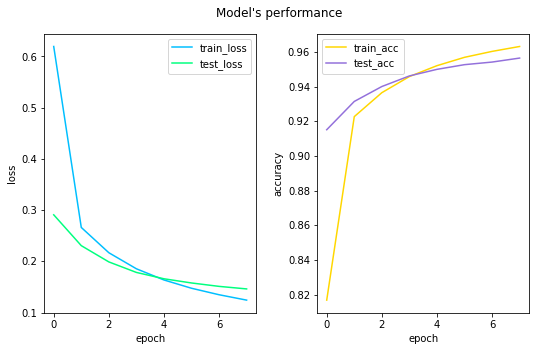

In [65]:
plot_history(history1)

Reassigning labels resulted in significant decrease in accuracy on training data, and slight decrease in accuracy on testing data, but it's not surprising with unbiased mislabeling. Let's say we randomize label for 80% of data. That means there is 20% chance that we didn't change correct label, and 8% that we randomly chose correct label. Which means that for each class k we have 28% chance that image was labeled as k, and 8% for any other class. So our network has expected training accuracy at 28%, but that doesn't mean it won't perform well on test data.

With 100% randomization our network will simply guess class with largest representation in data, what leaves us with ~10% accuracy.

Why we have such good generalization? Because neural networks "move" our input into high-dimensional space, creating high-dimensional features, and making separation easy. But that still holds for mislabeled data - images don't change in this setup. On the other hand, one could argue that 80% accuracy on MNIST isn't acceptable, since MNIST is often called a "machine learning unitest".

10.00% labels reassigned


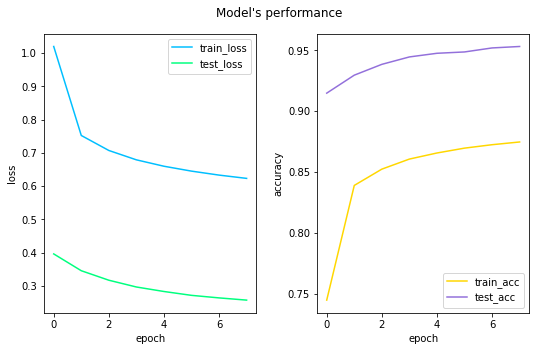


20.00% labels reassigned


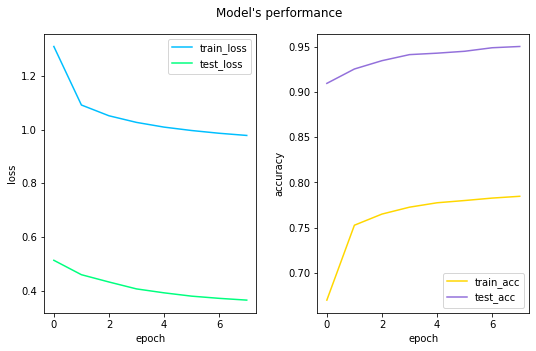


30.00% labels reassigned


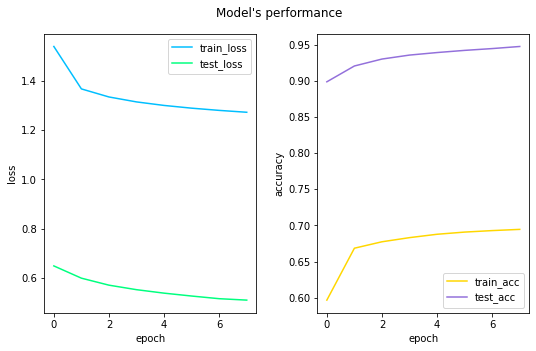


40.00% labels reassigned


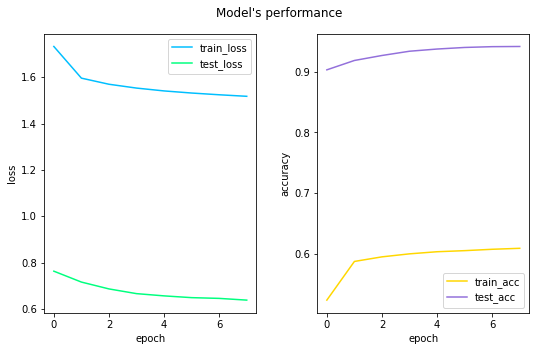


50.00% labels reassigned


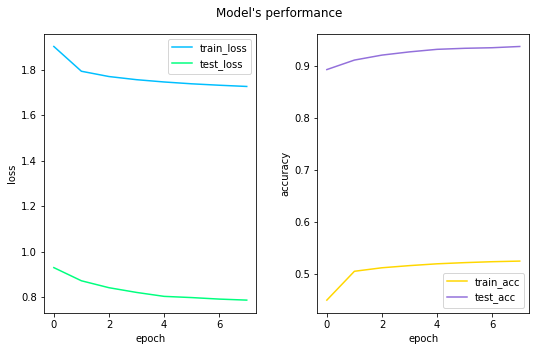


60.00% labels reassigned


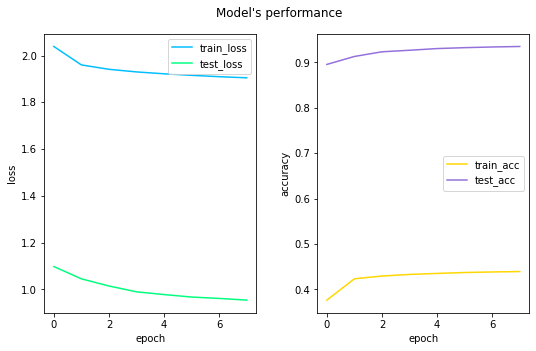


70.00% labels reassigned


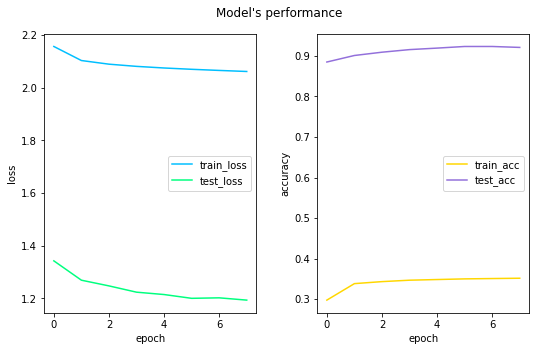


80.00% labels reassigned


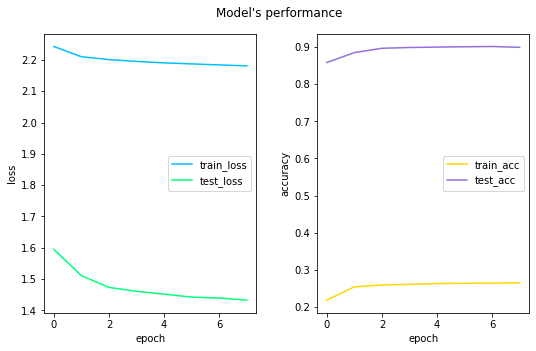


90.00% labels reassigned


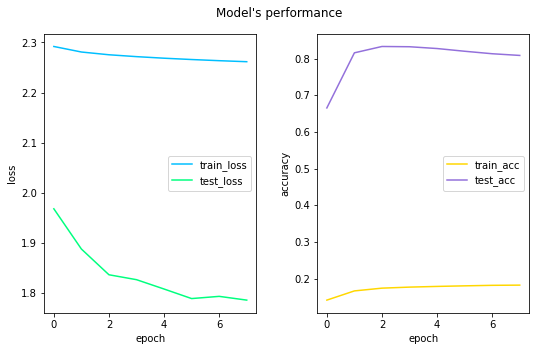


100.00% labels reassigned


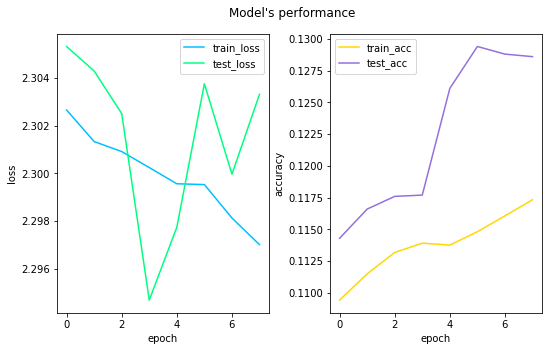

In [66]:
for x in xs[1:]:
    print(f'{x * 100:.2f}% labels reassigned')
    plot_history(history2[x])
    print()

Randomizing pixels means that whatever signal there is in our data, it will be noisy, so it will be harder for our model to learn good data representation. Still, it does not have a huge impact, because we draw pixels from distribution we have in our data, and each image consists mostly of 0s. So truly threatening change would be 1->0 or 0->1, where 0 is white and 1 black. Since we don't perform adversarial attack, it doesn't happen so often, so our accuracy is obviously worse, but still rather high.

10.00% pixels randomized


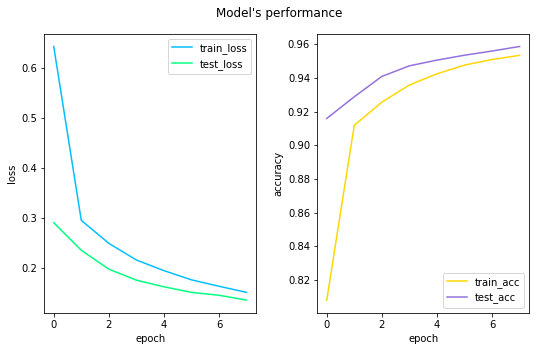


20.00% pixels randomized


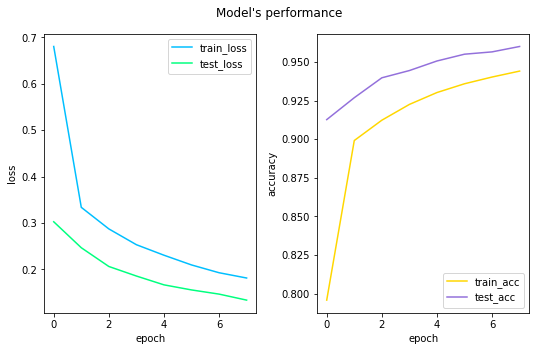


30.00% pixels randomized


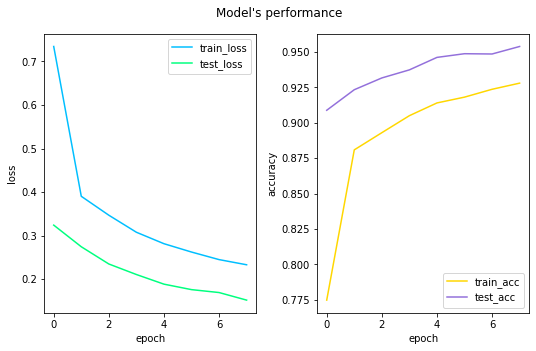


40.00% pixels randomized


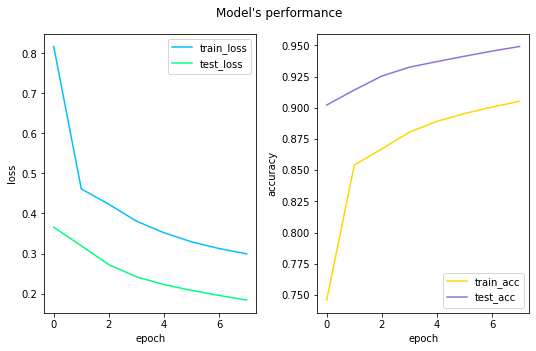


50.00% pixels randomized


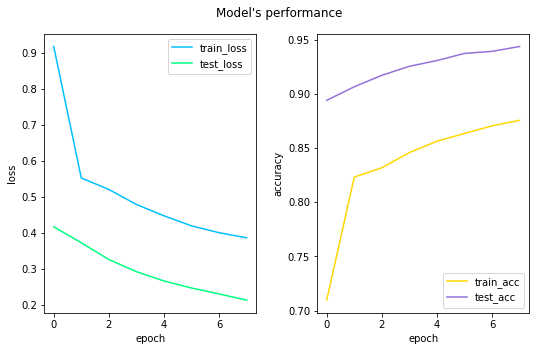


60.00% pixels randomized


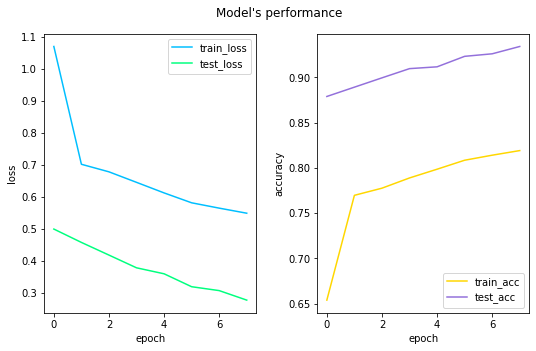


70.00% pixels randomized


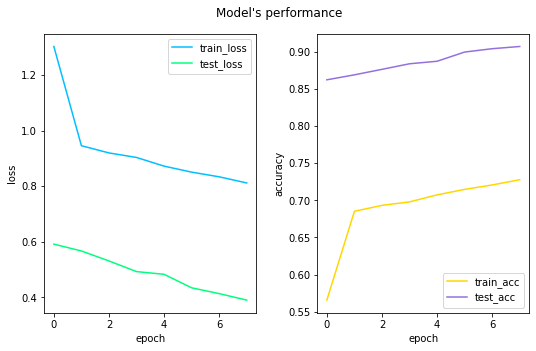


80.00% pixels randomized


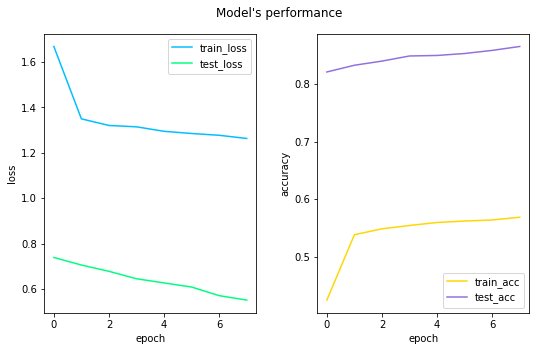


90.00% pixels randomized


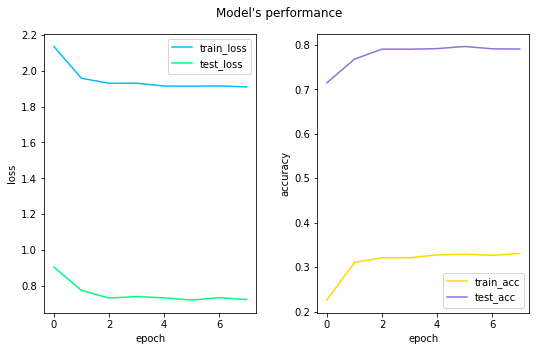


100.00% pixels randomized


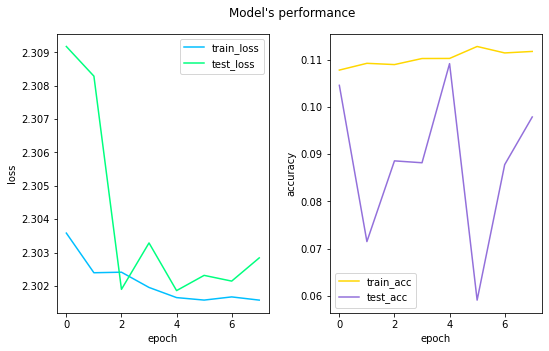

In [67]:
for x in xs[1:]:
    print(f'{x * 100:.2f}% pixels randomized')
    plot_history(history3[x])
    print()

Let's visualize, how probable is to set pixel value to 0, so to "erase a pixel".

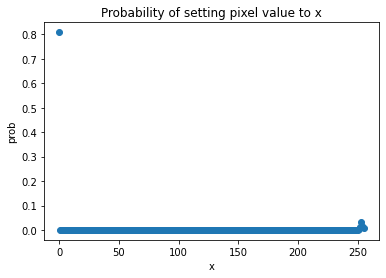

In [86]:
fig, ax = plt.subplots()
ax.plot([x/784 for x in pixels_dist.values()], 'o')
ax.set_title('Probability of setting pixel value to x')
ax.set_xlabel('x')
ax.set_ylabel('prob')
plt.show()

81% of all pixels in all images are 0s, which also mean that we will set any pixel value to 0 with 81% probability. If we added noise with more aggresive way (for example changing some 0s to 255s or another way around), network's performance would decrease more significantly.

Let's visualize differences between experiments.

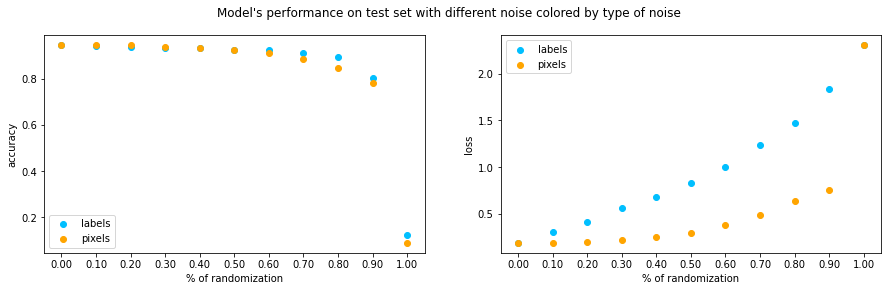

In [148]:
import pandas as pd

test_labels = pd.DataFrame.from_dict(
    {f'{k:.2f}': np.mean(v['test'], axis=0) for k, v in history2.items()},
    orient='index', columns=['loss', 'acc']
)
test_labels['randomized'] = 'labels'
test_pixels = pd.DataFrame.from_dict(
    {f'{k:.2f}': np.mean(v['test'], axis=0) for k, v in history3.items()},
    orient='index', columns=['loss', 'acc'],
)
test_pixels['randomized'] = 'pixels'
df = pd.concat([test_labels, test_pixels])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
for g, c in zip(['labels', 'pixels'], ['deepskyblue', 'orange']):
    subset = df[df.randomized == g]
    ax1.scatter(df.index.unique(), subset.acc, c=c, label=g)
    ax2.scatter(df.index.unique(), subset.loss, c=c, label=g)

ax1.legend(loc='lower left')
ax1.set_xlabel('% of randomization')
ax1.set_ylabel('accuracy')

ax2.legend(loc='upper left')
ax2.set_xlabel('% of randomization')
ax2.set_ylabel('loss')

plt.suptitle("Model's performance on test set with different noise colored by type of noise")
plt.show()

Label randomization means higher loss, since we use cross entropy loss. On the other hand, accuracy on test set decreases slower, so we have trade-off scenario.

To sum up, neural networks are good at generalization, and don't bother with some unbiased noise, at least when training on such easy dataset as MNIST.